In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import sqlite3
import math
import numpy as np
from adjustText import adjust_text
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.patches as patches
import unidecode
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
conn = sqlite3.connect(r"soccer_data.db")
raw_data = pd.read_csv(r"\big_5_leagues.csv",encoding='latin1').dropna(subset = 'Player')
raw_data['Player'] = raw_data['Player'].apply(lambda x:unidecode.unidecode(x))
positions = raw_data[((raw_data['player_position'] == 'Left-Back') | (raw_data['player_position'] =='Right-Back')) & (raw_data['player_age'] <24)]['Player'].tolist()
player_lst= pd.read_sql("Select Player from Players_Data WHERE Minutes_Played > 900",conn)['Player'].to_list()
player_lst = tuple([x for x in player_lst if x in positions])

In [3]:
def get_defensive_ability(player_lst):
    query = f"SELECT Player,Squad ,Nineties, Tackles_Won, Tackles, Dribblers_Tackled_Successfully_Percent, Successful_Pressures_Percent, Shots_Blocked,Interceptions,Aerial_Duels_Won_Percent FROM Players_Data WHERE player in{player_lst}"
    player = pd.read_sql(query,conn)
    player = player[player['Nineties'] > 1]
    against = pd.read_sql(f"SELECT Squad, Matches_Played ,Total_Shots, Passes_Attempted from Against_Squad_Data WHERE Squad in {tuple(player['Squad'].tolist())} ",conn)
    against.columns = ['Squad_Against','Matches_Played','Total_Shots_Against','Passes_Attempted_Against']
    player = pd.merge(player,against, how='left',left_on='Squad',right_on='Squad_Against')
    working_df = player[['Player','Squad' ,'Nineties','Dribblers_Tackled_Successfully_Percent','Successful_Pressures_Percent','Aerial_Duels_Won_Percent']]
    working_df['Tackle %'] = player['Tackles_Won']/player['Tackles'] * 100
    working_df['Blocked%'] = (player['Shots_Blocked']/player['Nineties']) / (player['Total_Shots_Against']/player['Matches_Played'])*100
    working_df['Interceptions %'] = (player['Interceptions']/player['Nineties'])/(player['Passes_Attempted_Against']/player['Matches_Played'])*100
    final = player[['Player','Squad']]
    cols = working_df.columns[2:].to_list()
    for col in cols:
        final[col]= (working_df[col]-working_df[col].mean())/working_df[col].std(ddof=0)
        final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
    final['Def'] = final['Dribblers_Tackled_Successfully_Percent'] *0.25 + final['Tackle %'] * 0.25 + final['Successful_Pressures_Percent'] *0.2 + final['Blocked%'] *0.05  + final['Interceptions %'] * 0.05 + final['Aerial_Duels_Won_Percent'] * 0.1 + final['Nineties']*0.10
    final['Def'] = final['Def'].rank(pct=True)*100
    final['Nineties'] = player['Nineties']
    present = final[['Player','Squad','Def','Nineties']]
    return present

In [4]:
def get_bpa(player_lst):
    query = f"SELECT Player,Squad ,Nineties, Non_Penalty_xG_and_xA_per_90, Completed_Passes_into_Att_Third, Crosses, Completed_Throughballs,Total_Pass_Progressive_Distance, Dribbles_Attempted, Shot_Creating_Actions_per_90, Successful_Dribbles_Percent, Progressive_Distance_of_Carries FROM Players_Data WHERE player in{player_lst}"
    player = pd.read_sql(query,conn)
    player = player[player['Nineties'] > 1]
    player['Total_Pass_Progressive_Distance_per_90'] = player['Total_Pass_Progressive_Distance']/player['Nineties']
    player['Progressive_Distance_of_Carries_per_90'] = player['Progressive_Distance_of_Carries']/player['Nineties']
    player['Crosses_per_90'] = player['Crosses']/player['Nineties']
    player['Dribbles_Attempted_per_90'] = player['Dribbles_Attempted']/player['Nineties']
    player['Completed_Throughballs_per_90'] = player['Completed_Throughballs']/player['Nineties']
    player['Completed_Passes_into_Att_Third_per_90'] = player['Completed_Passes_into_Att_Third']/player['Nineties']
    final = player[['Player','Squad']]
    cols = player.columns[2:].to_list()
    for col in cols:
        final[col]= (player[col]-player[col].mean())/player[col].std(ddof=0)
        final[col] = (final[col]-final[col].min())/(final[col].max()-final[col].min()) * 100
    final['BPA'] = final['Nineties']*0.1 + final['Non_Penalty_xG_and_xA_per_90'] * 0.15 + final['Crosses_per_90'] * 0.1 + final['Dribbles_Attempted_per_90'] * 0.05 + final['Completed_Throughballs_per_90'] * 0.1 + final['Completed_Passes_into_Att_Third_per_90'] * 0.15 +  final['Shot_Creating_Actions_per_90']*0.1 + final['Successful_Dribbles_Percent']*0.05 + final['Total_Pass_Progressive_Distance_per_90'] * 0.10 + final['Progressive_Distance_of_Carries_per_90']*0.10
    final['BPA'] = final['BPA'].rank(pct=True)*100
    final['Nineties'] = player['Nineties']
    present = final[['Player','Squad','BPA','Nineties']]
    return present

In [5]:
def get_plotting(df,threshold,minutes):
    # rotate = 1/math.sqrt(2)
    # df['x'] = df['Def'] * rotate - df['BPA']*rotate  #for labels
    # df['y'] = df['Def'] * rotate + df['BPA']*rotate 
    bad = df[(df['Def']<threshold) & (df['BPA']<threshold)]
    good = df[(df['Def']>threshold) & (df['BPA']>threshold)]
    other_players = [x for x in df['Player'] if x not in (bad['Player'].tolist() + good['Player'].tolist())]
    others = df[df['Player'].isin(other_players)]
    to_label = pd.concat([good,others])
    to_label = to_label[to_label['Nineties'] > minutes]
    good_no_label = good[good['Nineties'] < minutes]
    good_label = good[good['Nineties'] > minutes]
    return bad,good,others,to_label,good_no_label,good_label

In [6]:
def get_plotting(df,threshold,minutes):
    # rotate = 1/math.sqrt(2)
    # df['x'] = df['Def'] * rotate - df['BPA']*rotate  #for labels
    # df['y'] = df['Def'] * rotate + df['BPA']*rotate 
    bad = df[(df['Def']<threshold) & (df['BPA']<threshold)]
    good = df[(df['Def']>threshold) & (df['BPA']>threshold)]
    other_players = [x for x in df['Player'] if x not in (bad['Player'].tolist() + good['Player'].tolist())]
    others = df[df['Player'].isin(other_players)]
    to_label = pd.concat([good,others])
    to_label = to_label[to_label['Nineties'] < minutes]
    good_no_label = good[good['Nineties'] > minutes]
    good_label = good[good['Nineties'] < minutes]
    return bad,good,others,to_label,good_no_label,good_label

In [7]:
df = pd.merge(get_defensive_ability(player_lst),get_bpa(player_lst),on=['Player','Squad','Nineties'])
df = pd.merge(df,raw_data[['player_market_value_euro','Player']],how='left',on='Player')
df['Ratio'] = ((df['Def']+ df['BPA'])/2)/(df['player_market_value_euro']/1000000)
bad,good,others,to_label,good_no_label,good_label = get_plotting(df,50,20)


In [8]:
def setup_axes1(fig, rect,edge_color):

    tr = Affine2D().scale(2, 2).rotate_deg(45)

    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(0, 101, 0, 101))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    aux_ax = ax1.get_aux_axes(tr)
    for key in ax1.axis:
        # ax1.axis[key].set_visible(False)
        ax1.axis[key].major_ticklabels.set_visible(False)
        ax1.axis[key].toggle(all=False,label=True)
        ax1.axis[key].line.set_color(edge_color)
    return ax1, aux_ax

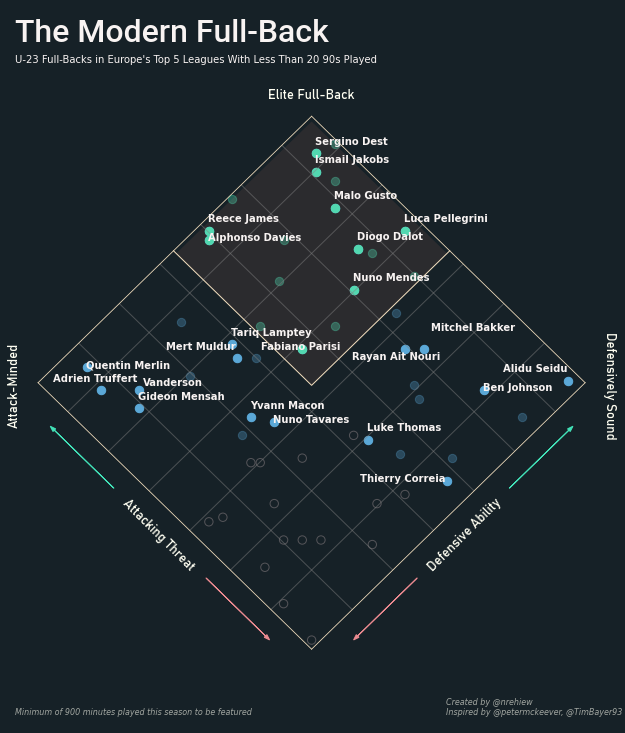

In [26]:
#styles 
bg_color = '#162127'
edge_color = '#F3DFBF'
good_color = '#42E2B8'
bad_color = '#EB8A90'
point_color = '#5BA8D7'
point_size = 70

title_color = '#F8F3F2'
title_size = 32
title_font = 'Roboto'

subtitle_size = 10

name_color = '#F8F3F2'
bad_edge = '#151617'

font = 'Bahnschrift'
text_size = 13
text_color = '#FFFFF2'
zone_color = '#E88873'

notes_size = 8

#main figure
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
ax.set_aspect('equal', 'box')
ax.axis('off')
fig.patch.set_facecolor(bg_color)
ax1,tilt_ax = setup_axes1(fig, 111,edge_color)
ax1.set_facecolor(bg_color)
ax1.get_xaxis().set_visible(False)

#scatters
bad_scatter = tilt_ax.scatter(bad['Def'],bad['BPA'],alpha=0.80,s=point_size,c='#646165',edgecolor='#646165',linewidths=1)
bad_scatter.set_facecolor("none")
tilt_ax.scatter(good['Def'],good['BPA'],c=good_color,s=point_size,alpha=0.3)
tilt_ax.scatter(others['Def'],others['BPA'],c=point_color,s=point_size,alpha=0.3)

tilt_ax.scatter(to_label['Def'],to_label['BPA'],c=point_color,s=point_size,alpha=1)
tilt_ax.scatter(good_no_label['Def'],good_no_label['BPA'],c=good_color,s=point_size,alpha=0.05)
tilt_ax.scatter(good_label['Def'],good_label['BPA'],c=good_color,s=point_size,alpha=1)
#names
names = []
for i,txt in enumerate(to_label['Player'].tolist()):
    text = tilt_ax.text(to_label['Def'].iloc[i]+1.1,to_label['BPA'].iloc[i]+1.5,txt,c=name_color,ha='center', va='center',fontweight = 'bold')
    #text.set_bbox(dict(facecolor=bg_color,alpha=0.4,edgecolor='none'))
    names.append(text)


#gridlines
plt.grid(color='grey',alpha=0.5, linestyle='-', linewidth=1)
tilt_ax.plot([50,50,101],[101,50,50],color = edge_color,linewidth = 1)
rect = patches.Rectangle((50,50),50,50,facecolor=zone_color,alpha=0.1)
tilt_ax.add_patch(rect)

#other text
tilt_ax.text(50,-6.5,'Defensive Ability',rotation =45,c=text_color,ha='center',va='center',fontfamily =font,size=text_size)
tilt_ax.arrow(33,-6,-22,0,color=bad_color,head_width =1)
tilt_ax.arrow(67,-6,22,0,color=good_color,head_width =1)

tilt_ax.text(-6.5,50,'Attacking Threat',rotation = - 45,c=text_color,ha='center',va='center',fontfamily = font,size=text_size)
tilt_ax.arrow(-6,33,0,-22,color=bad_color,head_width =1)
tilt_ax.arrow(-6,67,0,22,color=good_color,head_width =1)
tilt_ax.text(-5,105,'Attack-Minded',rotation=90,c=text_color,ha='center',va='center',fontfamily = font,size=text_size)
tilt_ax.text(105,-5,'Defensively Sound',rotation=-90,c=text_color,ha='center',va='center',fontfamily = font,size=text_size)
tilt_ax.text(105,105,'Elite Full-Back',c=text_color,ha='center',va='center',fontfamily = font,size=text_size)
#tilt_ax.annotate('Mads Roerslev',(0,0),(-25,25),arrowprops= dict(width=0.5,color=text_color,connectionstyle='arc3, rad=0.5',headwidth =5),c=name_color,fontweight = 'bold',ha='center',va='center',fontfamily = font,size=text_size)


#Title
plt.text(-155,330,'The Modern Full-Back',ha='left',c = title_color,fontfamily = title_font ,fontsize=title_size,va='center',fontweight ='roman')
plt.text(-155,316,"U-23 Full-Backs in Europe's Top 5 Leagues With Less Than 20 90s Played",c = title_color,fontsize=subtitle_size,ha='left',va='center')


#notes
plt.text(-155,-35,'Minimum of 900 minutes played this season to be featured',fontsize = notes_size,c=text_color,alpha=0.6,fontstyle='italic')
plt.text(70,-30,'Created by @nrehiew',fontsize = notes_size,c=text_color,alpha=0.6,fontstyle='italic')
plt.text(70,-35,'Inspired by @petermckeever, @TimBayer93',fontsize = notes_size,c=text_color,alpha=0.6,fontstyle='italic')

#padding 
plt.text(0,340,' ')
plt.text(0,-40,' ')

adjust_text(names, force_points=0.2,force_text=0.2,lim=1,ha='center', va='center')
plt.savefig('Completed/u23_fullbacks_others.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

In [9]:
defense = pd.read_csv('methodlogy.csv').iloc[0:7].sort_values('Unnamed: 1')
attack = pd.read_csv('methodlogy.csv').iloc[9:].sort_values('Unnamed: 1')

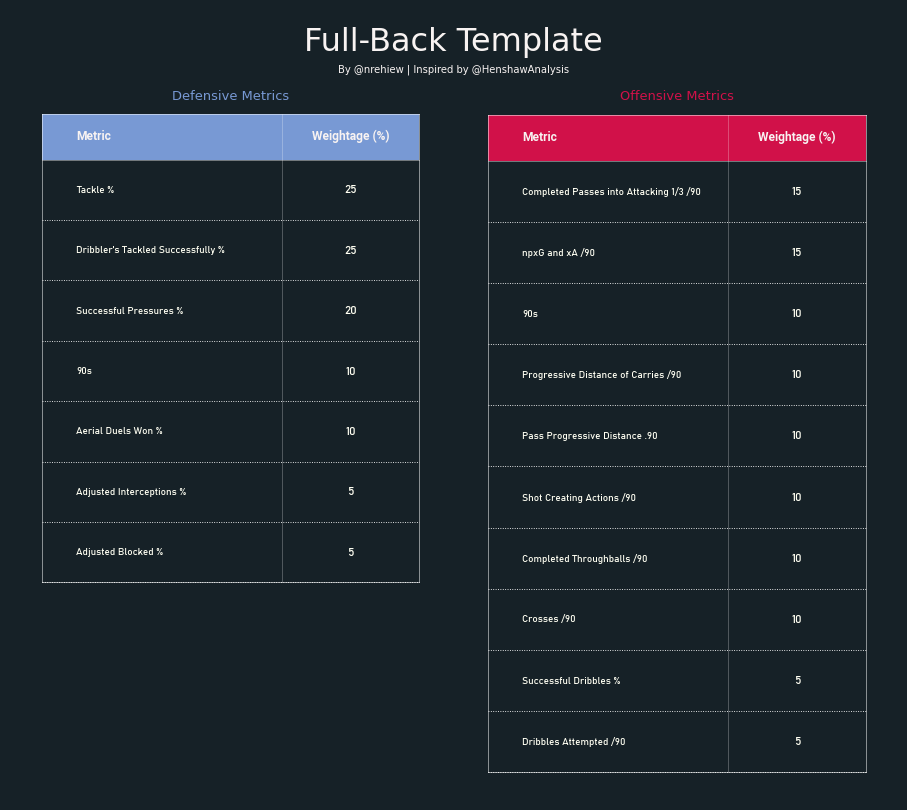

In [10]:
#styles
grid_color = 'white'
attack_color = '#D11149'
defense_color = '#7899D4'
text_size = 10
col_size =12
num_size = 12

def get_table(fig,ax,df,highlight):
    rows = df.shape[0]
    cols = 6
    ax.set_ylim(-1, rows + 1)
    ax.set_xlim(0, cols + .5)
    for row in range(rows):
        d = df.iloc[row].tolist()
        
        #metric 
        ax.text(x=1,y=row,s=d[0],va='center',ha='left',color=text_color,fontfamily = font,size=text_size)
        ax.text(x=5,y=row,s=int(d[1]),va='center',ha='center',color=text_color,fontfamily = font,size=num_size)

        #grid lines 
        ax.plot([0.5,cols],[row-0.5,row-0.5],ls=':',lw='.9',c=grid_color)

    #col names 
    ax.text(1, rows, 'Metric', weight='bold', ha='left',va='top',color =title_color,fontfamily = title_font,size=col_size)
    ax.text(5, rows, 'Weightage (%)', weight='bold', ha='center',va='top',color =title_color,fontfamily = title_font,size=col_size)

    #header divider
    ax.plot([0.5,cols],[rows-0.5,rows-0.5],lw='.8',c='white',alpha=0.5)

    #col dividers
    ax.plot([4,4],[-0.5,rows+0.25],lw='.5',c='white',alpha=0.5)

    #boundaries 
    ax.plot([0.5,0.5],[-0.5,rows+0.25],lw='1',c='white',alpha=0.5)
    ax.plot([cols,cols],[-0.5,rows+0.25],lw='1',c='white',alpha=0.5)
    ax.plot([0.5,cols],[rows+0.25,rows+0.25],lw='1',c='white',alpha=0.5)
    ax.plot([0.5,cols],[-0.5,-0.5],lw='1',c='white',alpha=0.5)
    ax.axis('off')

    #formatting 
    fig.patch.set_facecolor(bg_color)
    rect = patches.Rectangle((0.5,rows-0.5),5.5,0.75,fc=highlight,zorder=-1)
    ax.add_patch(rect)


#figure
fig,ax = plt.subplots()
fig.set_size_inches(16,10)
ax1 = ax.inset_axes([0,0,0.5,1])
ax2 = ax.inset_axes([0.5,-0.35,0.5,1.35])
ax.set_facecolor(bg_color)
ax.axis('off')

# tables
_ = get_table(fig,ax1,defense,defense_color)
_ = get_table(fig,ax2,attack,attack_color)

#Text 
plt.text(0.5,1.05,s='Full-Back Template',va='center',ha='center',color=title_color,size=title_size)
plt.text(0.5,1.0,s='By @nrehiew | Inspired by @HenshawAnalysis',va='center',ha='center',color=title_color,size=subtitle_size)

plt.text(0.25,0.95,'Defensive Metrics',va='center',ha='center',color=defense_color,size=13)
plt.text(0.75,0.95,'Offensive Metrics',va='center',ha='center',color=attack_color,size=13)

#Padding
plt.text(0.5,1.1,s=' ')
plt.savefig('Completed/full_back_template.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)